<a href="https://colab.research.google.com/github/sibyjackgrove/Kaggle_challenges/blob/master/LANL_Earthquake_Challenge_DNN_1D_CNN_LSTM_with_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook Content
- Earthquake prediction background & helpful resources
- Step 1 - Installing dependencies
- Step 2 - Importing dataset
- Step 3 - Exploratory data analysis
- Step 4 - Feature engineering (statistical features added) and creating training datasets
- Step 5 - Create and train models



# Step 1 - Install & Import Dependencies

In [1]:
#to access kaggle datasets
!pip install kaggle
!pip install numpy==1.15.0

In [2]:
#Utilities
import os
import time
import math

#data preprocessing
import pandas as pd
#math operations
import numpy as np

#data scaling
from sklearn.preprocessing import StandardScaler

#data visualization
import matplotlib.pyplot as plt

#Widgets (if the work)
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import display

#TensorFlow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,BatchNormalization,Conv1D,MaxPooling1D,GlobalAveragePooling1D,Dropout, LSTM
import tensorflow as tf
print(tf.test.gpu_device_name())
print(tf.__version__)


1.13.0-rc2


In [3]:
IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
if IS_COLAB_BACKEND:
  from google.colab import auth
  auth.authenticate_user() # Authenticates the backend and also the TPU using your credentials so that they can access your private GCS buckets


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
#@title visualization utilities [RUN ME]
"""
This cell contains helper functions used for visualization
and downloads only. You can skip reading it. There is very
little useful Keras/Tensorflow code here.
"""

# Matplotlib config
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")


    
# utility to display training and validation curves
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.grid(linewidth=1, color='white')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

# Step 2 - Import Dataset from Kaggle

In [5]:
# Colab's file access feature
from google.colab import files

#retrieve uploaded file
uploaded = files.upload()

#print results
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 70 bytes


In [6]:
#list competitions
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2506           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge       9951           False  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4081           False  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research         Knowledge         35           False  
competitive-data-science-predict-future-sales  2019-12-31 23:59:00  Playground           Kudos       2396           False  
two-sigma-financial-news                       2019-07-15 23:59:00  Featured          $100,000       2927           False  
LANL-Ear

In [9]:
#download earthquake data, will take 30-60 seconds (will only work after accepting competition rules)
!kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 28.5MB/s]
 97% 234M/242M [00:01<00:00, 147MB/s]
100% 242M/242M [00:01<00:00, 135MB/s]
100% 2.02G/2.03G [00:36<00:00, 40.1MB/s]
100% 2.03G/2.03G [00:36<00:00, 59.3MB/s]


In [10]:
#unzip training data for usage, will take about 5 minutes (its big)
!ls
!unzip train.csv.zip
!ls

adc.json  sample_data  sample_submission.csv  test.zip	train.csv.zip
Archive:  train.csv.zip
  inflating: train.csv               
adc.json     sample_submission.csv  train.csv
sample_data  test.zip		    train.csv.zip


# Step 3 - Exploratory Data Analysis

In [17]:
#Extract training data into a dataframe for further manipulation
train = pd.read_csv('train.csv', nrows=4095*100, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})#
print('Data frame shape:{}'.format(train.shape))
#print first n entries
train.head(4100)

Data frame shape:(409500, 2)


,acoustic_data,time_to_failure
0,12,1.469100
1,6,1.469100
2,8,1.469100
3,5,1.469100
4,8,1.469100
5,8,1.469100
6,9,1.469100
7,7,1.469100
8,-5,1.469100
9,3,1.469100


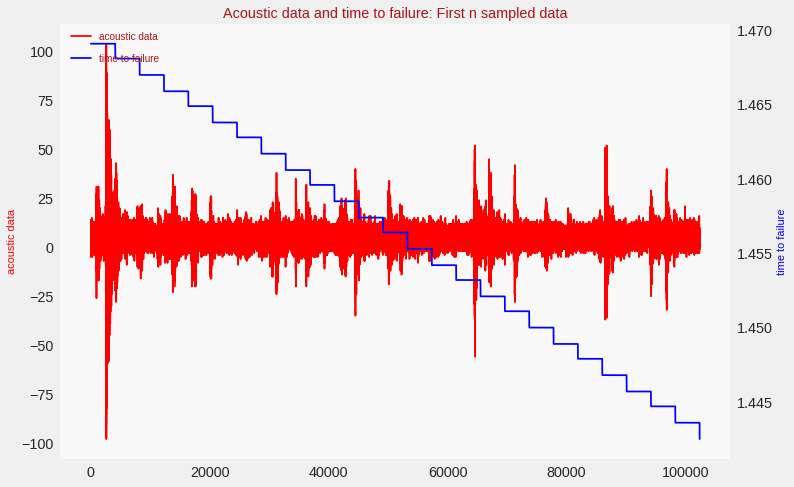

In [18]:
#visualize 1% of samples data, every 100th datapoint
n_samples = 4096*25+1
n_step = 4096
#train_ad_sample_df = train['acoustic_data'].values[::n_step]
#train_ttf_sample_df = train['time_to_failure'].values[::n_step]
train_ad_sample_df = train['acoustic_data'].values[:n_samples]
train_ttf_sample_df = train['time_to_failure'].values[:n_samples]

#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: First n sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
#del train_ad_sample_df
#del train_ttf_sample_df

![alt text](https://www.kaggleusercontent.com/kf/10364757/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..onsybg1U7xvMy-GjJdYtTA.RUVJoAZ7sxCnRNmM1WTjXMjmsl7raHI_FzIYc0vh0poV3hcKVMrr2GRPCwlr_urWqByjmahePNQlEFEsBBUO2meVZXzX-HjRQuU40ySqElezoc9HLF7nGBMCKPSYt-HPZAsGHnXBtkXV8qVOZlu5BWddQp7wthNJ5JkSftT41GM.vS5mBigypyc7eNri4zC2rQ/__results___files/__results___12_0.png)

# Step 4 - Feature Engineering and creating training dataset

### Run this if using 1-D CNN or LSTM

In [14]:
#Training data for 1D-CNN and LSTM
sequence_length=  4095 
n_sequences = 40000
num_features = 1
BATCH_SIZE = 128 # On TPU, this will be the per-core batch size. A Cloud TPU has 8 cores so tha global TPU batch size is 1024

X_train = pd.read_csv('train.csv', nrows=sequence_length*n_sequences,usecols =['acoustic_data'], dtype={'acoustic_data': np.int16})#.values.reshape(-1,4095,num_features) #Read values and reshape

Y_train = pd.read_csv('train.csv', nrows=sequence_length*n_sequences,usecols =['time_to_failure'], dtype={'time_to_failure': np.float64}).values.reshape(-1,4095,1) #Read values and reshape
Y_train = np.float32(Y_train[:,-1,-1]) #We only need the last value at end of sequence
print(X_train.shape,Y_train.shape)

#Scale input data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train_scaled = np.float32(X_train_scaled.reshape(-1,4095,num_features))
n_samples = X_train_scaled.shape[0]
print(X_train_scaled.shape,Y_train.shape)
print(X_train_scaled.dtype,Y_train.dtype)

(163800000, 1) (40000,)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int16 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int16 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


(40000, 4095, 1) (40000,)
float32 float32


###Run this if using Densely connected DNN

In [0]:
#lets create a function to generate some statistical features based on the training data
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)

#Training data for DNN
train = pd.read_csv('train.csv', iterator=True, chunksize=150000, dtype={'acoustic_data': np.int16})
num_statistical_features = 13
X_train_features = pd.DataFrame()
Y_train_features = pd.Series()
for df in train:
    features = gen_features(df['acoustic_data'])
    X_train_features = X_train_features.append(features, ignore_index=True)
    Y_train_features = Y_train_features.append(pd.Series(df['time_to_failure'].values[-1]))
#Scale input data
scaler = StandardScaler()
scaler.fit(X_train_features)
X_train_scaled = scaler.transform(X_train_features)
X_train_scaled = np.float32(X_train_scaled.reshape(-1,num_statistical_features))
Y_train = np.float32(Y_train_features.values) 
n_samples = X_train_scaled.shape[0]
print(X_train_scaled.shape,Y_train.shape)
print(X_train_scaled.dtype,Y_train.dtype)

### tf.data.Dataset: parse files and prepare training and validation datasets
Please read the [best practices for building](https://www.tensorflow.org/guide/performance/datasets) input pipelines with tf.data.Dataset

In [0]:
def get_training_dataset(batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled,Y_train.reshape(-1,1)))
    dataset = dataset.cache()  # this small dataset can be entirely cached in RAM, for TPU this is important to get good performance from such a small dataset
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)   # Shuffle, repeat, and batch the examples.
    dataset = dataset.repeat() # Mandatory for Keras for now
    dataset = dataset.batch(batch_size, drop_remainder=True) # drop_remainder is important on TPU, batch size must be fixed
    dataset = dataset.prefetch(-1)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
    return dataset                    # Return the dataset

# instantiate the datasets
training_dataset = get_training_dataset(BATCH_SIZE)

# For TPU, we will need a function that returns the dataset
training_input_fn = lambda: get_training_dataset(BATCH_SIZE)


# Step 5 - Create and train models

###Create either DNN, CNN or LSTM model

In [35]:
def create_earthquake_MLP_model():
    #Model #1 - MLP
    earthquake_MLP_model = Sequential() # Initialising the ANN
    earthquake_MLP_model.add(BatchNormalization(input_shape  = (num_statistical_features,)))
    earthquake_MLP_model.add(Dense(units = 20, activation = 'relu')) #, input_dim = 13
    earthquake_MLP_model.add(BatchNormalization())
    earthquake_MLP_model.add(Dense(units = 20, activation = 'relu'))
    earthquake_MLP_model.add(Dense(units = 20, activation = 'relu'))
    earthquake_MLP_model.add(Dense(units = 20, activation = 'relu'))
    earthquake_MLP_model.add(Dense(units = 20, activation = 'relu'))
    earthquake_MLP_model.add(Dense(units = 20, activation = 'relu'))

    earthquake_MLP_model.add(Dense(units = 10, activation = 'relu'))
    earthquake_MLP_model.add(Dense(units = 10, activation = 'relu'))
    earthquake_MLP_model.add(Dense(units = 10, activation = 'relu'))
    earthquake_MLP_model.add(Dense(units = 10, activation = 'relu'))
    earthquake_MLP_model.add(Dense(units = 10, activation = 'relu'))
    earthquake_MLP_model.add(Dense(units = 1, activation = 'linear'))
    earthquake_MLP_model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse'])
    earthquake_MLP_model.summary()
    
    return earthquake_MLP_model

def create_earthquake_CNN_model():
    #Model #2 - 1D CNN
    print('Creating CNN model')
    earthquake_CNN_model = Sequential()
    earthquake_CNN_model.add(Conv1D(100, 10, activation='relu', input_shape=(sequence_length, num_features)))
    earthquake_CNN_model.add(Conv1D(100, 10, activation='relu'))
    earthquake_CNN_model.add(MaxPooling1D(3))
    earthquake_CNN_model.add(Conv1D(100, 10, activation='relu'))
    earthquake_CNN_model.add(Conv1D(100, 10, activation='relu'))
    earthquake_CNN_model.add(MaxPooling1D(3))
    earthquake_CNN_model.add(Conv1D(100, 10, activation='relu'))
    earthquake_CNN_model.add(Conv1D(100, 10, activation='relu'))
    earthquake_CNN_model.add(MaxPooling1D(3))
    earthquake_CNN_model.add(Conv1D(160, 10, activation='relu'))
    earthquake_CNN_model.add(Conv1D(160, 10, activation='relu'))
    earthquake_CNN_model.add(GlobalAveragePooling1D())
    earthquake_CNN_model.add(Dropout(0.5))
    earthquake_CNN_model.add(Dense(1, activation='linear'))

    earthquake_CNN_model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse'])
    print(earthquake_CNN_model.summary())
    return earthquake_CNN_model

def create_earthquake_LSTM_model():
    #Model #2 - LSTM
    print('Creating CNN model')
    earthquake_LSTM_model = Sequential()
    earthquake_LSTM_model.add(LSTM(40, input_shape=(sequence_length, num_features), return_sequences=True))
    earthquake_LSTM_model.add(LSTM(20, return_sequences=False))

    earthquake_LSTM_model.add(Dense(100, activation='relu'))
    earthquake_LSTM_model.add(Dense(1, activation='linear'))

    earthquake_LSTM_model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse'])
    print(earthquake_LSTM_model.summary())
    
    return earthquake_LSTM_model

DECAY= False
# set up learning rate decay
if DECAY:
    lr_decay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.0001 + 0.02 * math.pow(0.5, 1+epoch), verbose=True)
else:
    lr_decay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001, verbose=True)

#trained_model = create_earthquake_LSTM_model()
#trained_model = create_earthquake_CNN_model()
trained_model = create_earthquake_MLP_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_v1_4 (Ba (None, 13)                52        
_________________________________________________________________
dense_24 (Dense)             (None, 20)                280       
_________________________________________________________________
batch_normalization_v1_5 (Ba (None, 20)                80        
_________________________________________________________________
dense_25 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_26 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_27 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_28 (Dense)             (None, 20)                420       
__________

###Train Model using TPU, GPU or CPU

In [36]:
EPOCHS = 500
steps_per_epoch = n_samples//BATCH_SIZE  # 60,000 items in this dataset
print(f'Iterations per epoch:{steps_per_epoch}')
tpu = None


# Counting steps and batches on TPU: the tpu.keras_to_tpu_model API regards the batch size of the input dataset
# as the per-core batch size. The effective batch size is 8x more because Cloud TPUs have 8 cores. It increments
# the step by +8 everytime a global batch (8 per-core batches) is processed. Therefore batch size and steps_per_epoch
# settings can stay as they are for TPU training. The training will just go faster.
# Warning: this might change in the final version of the Keras/TPU API.

try: # TPU detection
    tpu = tf.contrib.cluster_resolver.TPUClusterResolver() # Picks up a connected TPU on Google's Colab, ML Engine, Kubernetes and Deep Learning VMs accessed through the 'ctpu up' utility
    #tpu = tf.contrib.cluster_resolver.TPUClusterResolver('MY_TPU_NAME') # If auto-detection does not work, you can pass the name of the TPU explicitly (tip: on a VM created with "ctpu up" the TPU has the same name as the VM)
    
except ValueError:
    print('Training on GPU/CPU')

start_time = time.time()
if tpu: # TPU training
    strategy = tf.contrib.tpu.TPUDistributionStrategy(tpu)
    trained_model = tf.contrib.tpu.keras_to_tpu_model(trained_model, strategy=strategy)
    # Work in progress: reading directly from dataset object not yet implemented
    # for Keras/TPU. Keras/TPU needs a function that returns a dataset.
    print('Training using TPU!')
    history = trained_model.fit(training_input_fn, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, callbacks=[lr_decay]) # validation_data=validation_input_fn, validation_steps=1, callbacks=[lr_decay]
else: # GPU/CPU training
    print('Training using GPU!')
    history = trained_model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS)  #,validation_data=validation_dataset, validation_steps=1, callbacks=[lr_decay]

print(f'Time elapsed:{(time.time()-start_time)/60.0}')

Iterations per epoch:32
INFO:tensorflow:Querying Tensorflow master (grpc://10.10.198.58:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 15835482460749807878)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 16843138236576594323)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 4788155912491166667)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 7187841300277422876)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 11237785272940479581)
INFO:tensorflow:*** Available D

###Training history

dict_keys(['loss', 'mean_squared_error', 'lr'])


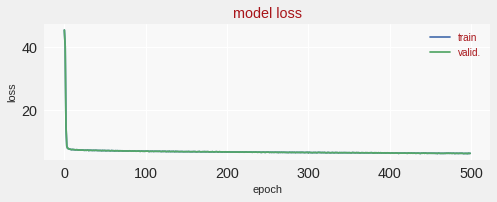

In [37]:
print(history.history.keys())
display_training_curves(history.history['loss'], history.history['mean_squared_error'], 'loss', 212)